In [140]:
import random
## Import tensorflow package for modeling
import torch
from torch.autograd import Variable
import torch.optim as optim

## Data processing
import pandas as pd
import numpy as np

## Min-max normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

## Plot the graph
import matplotlib.pyplot as plt
%matplotlib inline

## Initializing module
from sklearn.linear_model import LinearRegression
np.set_printoptions(suppress=True)

## Copy module
import copy

## Used to calculate the training time
import time
from dateutil.relativedelta import relativedelta

## Set the GUP environment
import os
import sys

from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker

In [141]:
## Set up the display
torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True, threshold=np.inf)

In [142]:
## Set seed for random function
random.seed(168)

# Data preparation

In [143]:
## 讀入原始資料
demand = pd.read_csv("demand.csv")

In [144]:
## 區分出 x 與 y 資料
demand_x = demand.iloc[:,:-1]
demand_y = pd.DataFrame(demand.iloc[:,-1])

In [145]:
## 排除前 6 個月需求皆為 0 的資料
demand_y = demand_y[~((demand_x["t-4"]==0) & (demand_x["t-3"]==0) & (demand_x["t-2"]==0) & (demand_x["t-1"]==0) & (demand_x["t"]==0) & (demand_x["t+1"]==0))]
demand_x = demand_x[~((demand_x["t-4"]==0) & (demand_x["t-3"]==0) & (demand_x["t-2"]==0) & (demand_x["t-1"]==0) & (demand_x["t"]==0) & (demand_x["t+1"]==0))]

## 重新排序
demand_x.reset_index(drop=True, inplace=True)
demand_y.reset_index(drop=True, inplace=True)

In [146]:
##Add new column "Number" to demand_y
demand_y.insert(0, "Number", demand_x["Number"])

In [147]:
## Store the date data
date = demand_x["Month_date"]
date = pd.to_datetime(date, format="%Y/%m/%d")
date = date.apply(lambda x: x + relativedelta(months=4)) 

## Delete the date data from the demand_x 
# demand_x.pop("Month_date")

In [148]:
## Set up the label encoder 
labelencoder = LabelEncoder()
demand_x_encode = copy.deepcopy(demand_x)
demand_y_encode = copy.deepcopy(demand_y)

In [149]:
## Encode the material number
demand_x_encode["Number"]=labelencoder.fit_transform(demand_x_encode["Number"])
demand_y_encode["Number"]=labelencoder.transform(demand_y_encode["Number"])

## 從 1 開始編碼
demand_x_encode["Number"] = demand_x_encode["Number"]+1
demand_y_encode["Number"] = demand_y_encode["Number"]+1

In [150]:
## Print out each meaning of code
material_num = [i for i in range(len(demand_x_encode["Number"].unique()))]
print(labelencoder.inverse_transform(material_num))

['CC1101040' 'CC1101050' 'CC110105002300' 'CC1101060' 'CC110106001800'
 'CC110106004900' 'CC1101080' 'CC110108002300' 'CC110108002800'
 'CC110108004300' 'CC110108004500' 'CC110108004700' 'CC1101100'
 'CC1102035' 'CC1102070' 'CC1102080' 'CC110208001800' 'CC110208002500'
 'CC110208003600' 'CC1102090' 'CC1102100' 'CC110210002800' 'CC1102120'
 'CC1102150' 'CC1102160' 'CC1102200' 'CC1102300' 'CC1102400']


In [151]:
demand_x_encode

,Number,Group,Month_date,Month,Mean,t-4,t-3,t-2,t-1,t,t+1
0,8,0,2013/5/1,11,43.08,20.000,50.000,109.500,0.000,0.0,79.0
1,8,0,2013/6/1,12,55.33,50.000,109.500,0.000,0.000,79.0,93.5
2,8,0,2013/7/1,1,47.00,109.500,0.000,0.000,79.000,93.5,0.0
3,8,0,2013/8/1,2,28.75,0.000,0.000,79.000,93.500,0.0,0.0
4,8,0,2013/9/1,3,39.92,0.000,79.000,93.500,0.000,0.0,67.0
...,...,...,...,...,...,...,...,...,...,...,...
2409,25,1,2020/2/1,8,358.08,0.000,214.000,162.735,206.265,0.0,1565.5
2410,25,1,2020/3/1,9,358.08,214.000,162.735,206.265,0.000,1565.5,0.0
2411,25,1,2020/4/1,10,322.42,162.735,206.265,0.000,1565.500,0.0,0.0
2412,25,1,2020/5/1,11,346.21,206.265,0.000,1565.500,0.000,0.0,305.5


In [152]:
def data_preparation(demand_x_encode, demand_y_encode):
    
#     fig, axes = plt.subplots(14, 2, figsize=(20,40))
    numbers = [number for number in demand_x_encode["Number"].unique()]

    x_train, y_train, x_test, y_test = np.array([]), np.array([]), np.array([]), np.array([])

    for i in range(len(numbers)):

        target_x = demand_x_encode[demand_x_encode["Number"]== numbers[i]]
        target_y = demand_y_encode[demand_y_encode["Number"]== numbers[i]]

        target_x.reset_index(inplace=True, drop=True)
        target_y.reset_index(inplace=True, drop=True)

        target_x_volume = np.array(target_x)
        target_y_volume = np.array(target_y["t+2"])


        ## Handling outlier
        #選定幾倍 IQR 值以外去除
        n=0

        #IQR = Q3-Q1
        IQR = np.percentile(target_y_volume,75) - np.percentile(target_y_volume,25)

        #outlier = Q3 + n*IQR 
        upper = np.percentile(target_y_volume,75)+n*IQR
        lower = np.percentile(target_y_volume,25)-n*IQR

        ## 方法一： outlier 直接排除

        #outlier = Q3 + n*IQR 
        target_x_volume = target_x_volume[np.where(target_y_volume <= upper)[0]]
        target_y_volume = target_y_volume[target_y_volume <= upper]

        #outlier = Q1 - n*IQR 
        target_x_volume = target_x_volume[np.where(target_y_volume >= lower)[0]]
        target_y_volume = target_y_volume[target_y_volume >= lower]


        ## 方法二： outlier 取代成上、下限值
    #     target_y_volume[np.where(target_y_volume > upper)] = upper
    #     target_y_volume[np.where(target_y_volume < lower)] = lower


        x_train = np.append(x_train, target_x_volume[:int(target_x_volume.shape[0]*0.8)])
        y_train = np.append(y_train, target_y_volume[:int(target_x_volume.shape[0]*0.8)])

        x_test = np.append(x_test, target_x_volume[int(target_x_volume.shape[0]*0.8):])
        y_test = np.append(y_test, target_y_volume[int(target_x_volume.shape[0]*0.8):])

        # 印結果
#         number_text = labelencoder.inverse_transform([numbers[i]-1])[0]
#         axes[i//2][i%2].set_title("Material number: %s" %(number_text))
#         axes[i//2][i%2].plot(target_y_volume)
#         axes[i//2][i%2].axhline(y=IQR, color="red")
#         axes[i//2][i%2].axhline(y=upper, color="orange")
#         axes[i//2][i%2].axhline(y=lower, color="orange")

    x_train = x_train.reshape(-1, demand_x_encode.shape[1])
    x_test = x_test.reshape(-1, demand_x_encode.shape[1])

    zip_list = list(zip(x_train.tolist(), y_train.tolist()))
    random.shuffle(zip_list)
    demand_x_shuffle, demand_y_shuffle = zip(*zip_list)
    x_train, y_train = np.array(demand_x_shuffle), np.array(demand_y_shuffle)

    ## 印出資料尺寸用以確認資料正確與否
    # print("The shape of x_train:",x_train.shape)
    # print("The shape of y_train:",y_train.shape)
    # print("The shape of x_test:",x_test.shape)
    # print("The shape of y_test:",y_test.shape)

    ## 印出前 10 筆資料看看
    # print("x:\n", x_train[:10])
    # print("y:\n", y_train[:10])

#     plt.tight_layout()
    return (x_train, y_train, x_test, y_test)

# Modeling

## Print out some info

In [153]:
def accuracy_cacl(pred_value, actual_value):
    
#     yo, loss, tape = network.forward()
    performance = []

    performance.append(torch.mean(torch.abs(pred_value - actual_value)))
    performance.append(torch.sqrt(torch.mean((pred_value - actual_value)**2)))
    
    for i in range(500, 600, 100):
        correct_times = torch.nonzero(torch.abs(pred_value - actual_value) <= i)
        accuracy = correct_times.shape[0]/pred_value.shape[0]
        performance.append(accuracy)
    
    performance.append(torch.std(torch.abs(pred_value - actual_value)))
    
    return performance

In [154]:
def plot_result(name, pred_value, actual_value):
    
#     fig, ax = plt.subplots(2,2,figsize=(20,10), sharex=True, sharey=True)
    fig, ax = plt.subplots(1,figsize=(20,10), sharex=True, sharey=True)
#     ax.set_xlim(0,pred_value.shape[0])  
    
    
    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.plot(pred_value, label="Forecasted price")
    ax.plot(actual_value, label="Actual")
    ax.set_title("Forecasted performance")
    ax.legend()
        
    #fig.text(0.5, 0, "Stage of training", ha='center', fontsize=20)
    #fig.text(0, 0.5, "Copper price value", va='center', rotation='vertical')

    fig.suptitle("In the %s process"%(name))
    fig.tight_layout()
#     fig.savefig("In the %s process in the M=%d window.png"%(name, block_index),dpi=300,bbox_inches='tight')

In [155]:
def plot_adopted_node(network):
    
    fig, ax = plt.subplots(figsize=(20,5))
#     ax.set_xticklabels([i for i in range(network.nb_node_acceptable.shape[0]+5)])
    
    ax.set_title("Total amount of adopted hidden nodes in the training process")
    ax.plot(network.nb_node_acceptable,"-o")

    ax.set_xlabel("Stage of training")
    ax.set_ylabel("Hidden nodes")
    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#     fig.savefig("hidden nodes in the training process in the M=%d window"%(block_index),dpi=300,bbox_inches='tight')

In [156]:
def evaluation_table(evaluation_results, name, performance, nb_step4, nb_step6_1, nb_step6_2, adopted_hidden_node):


    new_result = pd.DataFrame({

       
        "Stage":name,
        "MAE" : round(performance[0].item(),2),
        "RMSE" : round(performance[1].item(),2),
        "Accuracy(500)" : [round(performance[2]*100,2)],
        "SD of absolute error":round(performance[3].item(),2),
        "Step4":nb_step4,
        "Step6.1":nb_step6_1,
        "Step6.2":nb_step6_2,
        "Adopted_hidden_node":adopted_hidden_node
    })

    evaluation_results = evaluation_results.append(new_result, ignore_index=True)
    
    return evaluation_results

In [157]:
def validation(network, nb_step4, nb_step6_1, nb_step6_2, x_train, y_train, x_test, y_test, evaluation_results_train, evaluation_results_test):

    ## Training_Step
    print("<<Training step>>")
    yo, loss= network.forward()
    
    ## N - outlier
    pre_train = yo.data.cpu()
    true_train = network.y.data.cpu()
    
    pred_value_train = torch.FloatTensor(pre_train)
    actual_value_train = torch.FloatTensor(true_train)
    accuracy_train = accuracy_cacl(pred_value_train,actual_value_train)

    ## B
    pred_value_test = torch.FloatTensor(network.forecast(x_test).data.cpu())
    accuracy_test = accuracy_cacl(pred_value_test, y_test)
    
    total_time = nb_step4 + nb_step6_1 + nb_step6_2
    print("<<The percentage of each step>>")
    print("Step 4: %.2f%%"%((nb_step4/total_time)*100))
    print("Step 6.1: %.2f%%"%((nb_step6_1/total_time)*100))
    print("Step 6.2: %.2f%%"%((nb_step6_2/total_time)*100))

    print("-"*60)
    print("Total frequency of cramming occurrences:",nb_step6_2)

    print("-"*60)
    print("The amount of hidden node that be pruned:",network.nb_node_pruned)

    print("-"*60)
    adopted_hidden_node = network.nb_node_acceptable[-1].item()
    print("The amount of adopted hidden nodes:",network.nb_node_acceptable[-1].item())

    print("-"*60)
    print("<<Accuracy in training step>>")
    print("The MAE: %.2f" %(accuracy_train[0]))
    print("SD of error: %.2f" %(accuracy_train[3]))
    print("The RMSE: %.2f" %(accuracy_train[1]))
    print("The accuracy(500): %.2f%%" %(accuracy_train[2]*100))

    print("-"*60)
    print("<<Accuracy in inferencing step>>")
    print("The MAE: %.1f" %(accuracy_test[0]))
    print("SD of error: %.2f" %(accuracy_test[3]))
    print("The RMSE: %.1f" %(accuracy_test[1]))
    print("The accuracy(500): %.1f%%" %(accuracy_test[2]*100))
    print("-"*60)

    predict_value = pd.DataFrame({
        "Actual":y_test.reshape((-1,)),
        "SS": torch.reshape(pred_value_test,(-1,)).numpy()
    })
    
    predict_value.to_csv("pre_result.csv", index=False)
    
    evaluation_table_train = evaluation_table(evaluation_results_train, "Training", accuracy_train,nb_step4, nb_step6_1, nb_step6_2,adopted_hidden_node)
    evaluation_table_test = evaluation_table(evaluation_results_test, "Inferencing", accuracy_test,nb_step4, nb_step6_1, nb_step6_2,adopted_hidden_node)
    pre_LDSS = network.forecast(x_test).data.cpu()
#     pd.DataFrame(pre_LDSS).to_csv("pre_LDSS_%d.csv"%(block_index), index=False)
    
#     if block_index%5==0:
    plot_result("training",pred_value_train, actual_value_train)
    plot_result("inferencing",pred_value_test, y_test)
    plot_adopted_node(network)
    
    return(evaluation_table_train, evaluation_table_test)

### Network class

In [158]:
class Network(torch.nn.Module):
    
    def __init__(self, nb_neuro, x_train_scaled, y_train_scaled):
        
        super(Network, self).__init__()
        self.linear1 = torch.nn.Linear(x_train_scaled.shape[1], nb_neuro).cuda()
        self.linear2 = torch.nn.Linear(nb_neuro, 1).cuda()
        
        
        # Stop criteria - threshold
        self.threshold_for_error = 0.12
        self.threshold_for_lr = 1e-4
        
        # Input data 
        self.x = torch.FloatTensor(x_train_scaled).cuda()
        self.y = torch.FloatTensor(y_train_scaled).cuda()
        
        # Learning rate
        self.learning_rate = 1e-3
        
        # Whether the network is acceptable, default as False
        self.acceptable = False
        
        # Some record for experiment
        self.nb_node_pruned = 0
        self.nb_node_acceptable=torch.IntTensor([nb_neuro])
        
        self.limit = nb_neuro
        
    ## Forecast the test data
    def forecast(self, x_test):
    
        x_test = torch.FloatTensor(x_test).cuda()
        activation_value = self.linear1(x_test).clamp(min=0)
        forecast_value = self.linear2(activation_value)
       
        return forecast_value

    ## Reset the x and y data
    def setData(self, x_train_scaled, y_train_scaled):
        self.x = torch.FloatTensor(x_train_scaled).cuda()
        self.y = torch.FloatTensor(y_train_scaled).cuda()
    
    ## Add the new data to the x and y data
    def addData(self, new_x_train, new_y_train):

        self.x = torch.cat([self.x, new_x_train.reshape(1,-1).cuda()],0)
        self.y = torch.cat([self.y, new_y_train.reshape(-1,1).cuda()],0)
    
    ## forward operation
    def forward(self, reg_strength=0):
       
        y1 = self.linear1(self.x).clamp(min=0)
        yo = self.linear2(y1)

        # performance measure
        param_val= torch.sum(torch.pow(self.linear2.bias.data,2))+torch.sum(torch.pow(self.linear2.weight.data,2))+torch.sum(torch.pow(self.linear1.bias.data,2))+torch.sum(torch.pow(self.linear1.weight.data,2))
        reg_term= reg_strength/((self.linear2.bias.data.shape[0]*(self.linear2.weight.data.shape[1]+1)) +(self.linear1.bias.data.shape[0]*(self.linear1.weight.data.shape[1]+1)))*param_val
        loss = torch.nn.functional.mse_loss(yo,self.y)+reg_term
        loss = loss.cuda()
        return(yo, loss)

    # backward operation
    def backward_Adadelta(self,loss):    

        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

### Initializing module (Check)

In [159]:
def initializing(network, initial_x, initial_y):
#     print("Initializing module")
    ## Find each minimum output value y
    min_y = torch.min(initial_y, axis=0)
    
    ## Subtract min_y from each y
    res_y = initial_y-min_y.values
    
    ## Use linear regression to find the initial W1,b1,Wo,bo
    reg = LinearRegression().fit(initial_x, res_y)
    
    ## Set up the initial parameter of the network
    network.linear1.weight = torch.nn.Parameter(torch.FloatTensor(reg.coef_).cuda())
    network.linear1.bias = torch.nn.Parameter(torch.FloatTensor(reg.intercept_).cuda())
    network.linear2.weight=torch.nn.Parameter(torch.FloatTensor([[1]]).cuda())
    network.linear2.bias = torch.nn.Parameter(torch.FloatTensor(min_y.values).cuda())
    
#     print(reg.coef_)
#     print(reg.intercept_)

    ## Set up the acceptable of the initial network as True
    network.acceptable =True

### Selecting module (Check)

In [160]:
def selecting(network, x_train_scaled, y_train_scaled):
    
#     print("<<Selecting module>>")
    loss = []
    temp_network = copy.deepcopy(network)
    
    ## Put each data into network to calculate the loss value
    for i in range(x_train_scaled.shape[0]):
        temp_network.setData(x_train_scaled[i].reshape(1,-1), y_train_scaled[i].reshape(-1,1))
        loss.append((temp_network.forward()[1].item(),i))
#         print(network.state_dict())
#         print(temp_network.y)
#         print("-"*20)
#         print(temp_network.forward()[1])
#         print("-"*20)
#     ## Sort the data according to the loss value from smallest to largest, and save the data index in sorted_index
    sorted_index = [sorted_data[1] for sorted_data in sorted(loss, key = lambda x:x[0])]
    
    
    ## Print out some info for debug
#     print("The loss value of k:",loss[sorted_index[0]])
#     print("The second_loss value of k:",loss[sorted_index[1]])
#     print("Selecting module finish!")
#     print("Loss",loss)
#     print(network.state_dict())
    
    return sorted_index

### Matching

In [161]:
def matching(network):

    times_enlarge=0
    times_shrink=0
    
#     print("<<Matching module>>")
#     print("threshold_for_error:",network.threshold_for_error)
    
    ## Set up the learning rate of the network
    network.learning_rate = 1e-3
    network.acceptable = False
    initial_network = copy.deepcopy(network)

    yo, loss = network.forward()
    
    if torch.all(torch.abs(yo-network.y) <= network.threshold_for_error):
#         print("Matching finished (firstly) - the network is acceptable")
        network.acceptable = True
#         print("Matching firstly finished - the network is acceptable")
#         print("Number of enlarge:",times_enlarge)
#         print("Number of shrink:",times_shrink)
        return(network)
    
    else:
    
        while True:

            yo, loss = network.forward()
            network_pre = copy.deepcopy(network)
            loss_pre = loss
            
            # Backward and check the loss performance of the network with new learning rate
            network.backward_Adadelta(loss)
            yo, loss = network.forward()

            # Confirm whether the loss value of the adjusted network is smaller than the current one
            if loss <= loss_pre and torch.all(torch.abs(yo-network.y) <= network.threshold_for_error):
       
                network.acceptable = True
#                 print("Matching finished - the network is acceptable")
#                 print("Number of enlarge:",times_enlarge)
#                 print("Number of shrink:",times_shrink)
                return(network)

            elif loss <= loss_pre:
                
                times_enlarge+=1
                network.learning_rate *= 1.2

            else:         

                # Identify whether the current learning rate is less than the threshold
                if network.learning_rate <= network.threshold_for_lr:

                    # If true, set the acceptable of the network as false and return it
                    network.acceptable = False
#                     print("Matching finished - the network is Unacceptable")
#                     print("Number of enlarge:",times_enlarge)
#                     print("Number of shrink:",times_shrink)
                    return(initial_network)

                # On the contrary, restore w and adjust the learning rate
                else:
                    
                    # Restore the papameter of the network
                    network = copy.deepcopy(network_pre)
                    times_shrink+=1
                    network.learning_rate *= 0.7

### Matching for reorganizing

In [162]:
def matching_for_reorganizing(network):

    times_enlarge=0
    times_shrink=0
    
#     print("<<Matching module for reorganizing>>")
#     print("threshold_for_error:",network.threshold_for_error)
    
    ## Set up the learning rate of the network
    network.learning_rate = 1e-3
    network.acceptable = False
    initial_network = copy.deepcopy(network)
    yo, loss = network.forward()
    
    if torch.all(torch.abs(yo-network.y) < network.threshold_for_error):

        network.acceptable = True
#         print("Matching(o) first finished - the network is acceptable")
#         print("Number of enlarge:",times_enlarge)
#         print("Number of shrink:",times_shrink)
        return(network)
    
    else:
        
        for i in range(500):
            
            yo, loss = network.forward()
            network_pre = copy.deepcopy(network)
            loss_pre = loss
#             print("<前Loss>",loss)
#             print(network.state_dict())
            # Backward and check the loss performance of the network with new learning rate
            network.backward_Adadelta(loss)
            yo, loss = network.forward()
#             print("<後Loss>",loss)
#             print(network.state_dict())
            # Confirm whether the loss value of the adjusted network is smaller than the current one
            if loss <= loss_pre and torch.all(torch.abs(yo-network.y) < network.threshold_for_error):

                # If true, multiply the learning rate by 1.2
                network.acceptable = True
#                 print("Matching finished(o) - the network is acceptable")
#                 print("Number of enlarge:",times_enlarge)
#                 print("Number of shrink:",times_shrink)
                return(network)

            elif loss <= loss_pre:
                
#                 print("*1.2")
                times_enlarge+=1
                network.learning_rate *= 1.2


            else:         

                # Identify whether the current learning rate is less than the threshold
                if network.learning_rate <= network.threshold_for_lr:

                    # If true, set the acceptable of the network as false and return it
                    network.acceptable = False
#                     print("Matching finished(o) - the network is Unacceptable")
#                     print("Number of enlarge:",times_enlarge)
#                     print("Number of shrink:",times_shrink)
                    return(initial_network)

                # On the contrary, restore w and adjust the learning rate
                else:
#                     print("*0.7")
                    # Restore the papameter of the network
                    network = copy.deepcopy(network_pre)
                    times_shrink+=1
                    network.learning_rate *= 0.7
                
        network.acceptable = False
#         print("Matching的第%d回合"%(i+1))
#         print("Matching finished - the network is Unacceptable")
#         print("Number of enlarge:",times_enlarge)
#         print("Number of shrink:",times_shrink)
        return(initial_network)

## Cramming module (Check)

In [163]:
def cramming(network):
    
    torch.manual_seed(168)
#     print("<<Cramming module>>")
#     print("threshold_for_error:",network.threshold_for_error)
    
    ## Find unsatisfied data:K
    yo, loss = network.forward()
    undesired_index = torch.nonzero(torch.abs(yo-network.y) > network.threshold_for_error+0.1, as_tuple =False)

    ## Print out the undesired_index for debug
#     print("不滿足個數：",undesired_index.shape[0])
#     print("The index of the undesired data:",undesired_index)

    
    if undesired_index.shape[0] == 1:
        
        # Unsatisfied situation
        ## Find the index of the unsatisfied data
        k_data_num = undesired_index[0][0]

        undesired_data = torch.reshape(network.x[k_data_num,:], [1,-1])

        ## Remove the data that does not meet the error term
        remain_tensor = network.x[:k_data_num,:]

        ## Use the random method to find out the gamma and zeta
        while True:

            ## Find m-vector gamma: r
            ## Use the random method to generate the gamma that can make the conditions met
            gamma = torch.rand(size=[1,network.x.shape[1]]).cuda()
            subtract_undesired_data = torch.sub(remain_tensor, undesired_data)
            matmul_value = torch.mm(gamma,torch.t(subtract_undesired_data))

            if torch.all(matmul_value != 0):
                break

        while True:

            ## Find the tiny value: zeta
            ## Use the random method to generate the zeta that can make the conditions met
#             zeta = torch.mul(0.001,torch.rand(size=[1])).cuda()
            zeta = torch.rand(size=[1]).cuda()
            if torch.all(torch.mul(torch.add(zeta,matmul_value),torch.sub(zeta,matmul_value))<0):
                break

       

        k_l = undesired_index[0][1]
        
        ## The weight of input layer to hidden layer I
        w10 = gamma
        w11 = gamma
        w12 = gamma

        W1_new = torch.cat([w10,w11,w12],0)
        

        ## The bias of input layer to hidden layer I
        matual_value = torch.mm(gamma,torch.t(undesired_data))
       
        
        b10 = torch.sub(zeta,matual_value)
        b11 = -1*matual_value
        b12 = torch.sub(-1*zeta,matual_value)

        b1_new = torch.reshape(torch.cat([b10,b11,b12],0),[3])

        gap = network.y[k_data_num, k_l]-yo[k_data_num, k_l]

        
        wo0_value = gap/zeta
        wo1_value = (-2*gap)/zeta
        wo2_value = gap/zeta

        Wo_new = torch.reshape(torch.cat([wo0_value,wo1_value,wo2_value],0),[1,-1])

        ## Add new neuroes to the network
        network.linear1.weight = torch.nn.Parameter(torch.cat([network.linear1.weight.data, W1_new]))
        network.linear1.bias = torch.nn.Parameter(torch.cat([network.linear1.bias.data, b1_new]))
        network.linear2.weight = torch.nn.Parameter(torch.cat([network.linear2.weight.data, Wo_new],1))


        yo, loss = network.forward()
        
        ## Determine if cramming is successful and print out the corresponding information
        if torch.all(torch.abs(yo-network.y) <= network.threshold_for_error):
            network.acceptable = True 
            print("Cramming success!")

        else:
            print("Cramming failed!")
    
    else:
        print("條件不合，不能Cramming")

### Regularizing module (Check)

In [164]:
def regularizing(network):

#     print("<<Regularizing module>>")
#     print("threshold_for_error:",network.threshold_for_error)
    ## Record the number of executions
    times_enlarge = 0
    times_shrink = 0
    ## Set up the learning rate of the network
    network.learning_rate = 1e-3

    ## Set epoch to 100
    for i in range(100):

        ## Store the parameter of the network
        network_pre = copy.deepcopy(network)
        yo, loss = network.forward(1e-3)
        loss_pre = loss

#         print("調整前的network")
#         print("<<變數>>")
#         print(network.state_dict())
#         print("<<Loss值>>")
#         print(loss)
#         print("差異")
#         print(torch.abs(yo-network.y))
        
        ## Backward operation to obtain w'
        network.backward_Adadelta(loss)
        yo, loss = network.forward(1e-3)
#         print("調整後的network")
#         print("<<變數>>")
#         print(network.state_dict())
#         print("<<Loss值>>")
#         print(loss)
#         print("差異")
#         print(torch.abs(yo-network.y))
         # Confirm whether the adjusted loss value is smaller than the current one
        if loss <= loss_pre:
            
            ## Identify that all forecast value has met the error term
            if torch.all(torch.abs(yo-network.y) < network.threshold_for_error):
                
                ## If true, multiply the learning rate by 1.2
#                 print("*1.2")
                network.learning_rate *= 1.2
                times_enlarge += 1
#                 print("Regularizing %d process - Enlarge"%i)
#                 print("第\"%d\"回合是成功執行regularizing"%(i+1))
#                 print("差異")
#                 print(torch.abs(yo-network.y))

            else:

                ## Else, restore w and end the process
                network = copy.deepcopy(network_pre)
#                 print("Regularizing結束-因為沒有顧好預測誤差")
#                 print("Number of enlarge:",times_enlarge)
#                 print("Number of shrink:",times_shrink)
#                 print("Regularizing result: Unable to meet the error term")
                return(network)

        # If the adjusted loss value is not smaller than the current one
        else:

            ## If the learning rate is greater than the threshold for learning rate
            if network.learning_rate > network.threshold_for_lr:
                
                ## Restore the w and multiply the learning rate by 0.7
                network = copy.deepcopy(network_pre)
#                 print("*0.7")
                network.learning_rate *= 0.7
                times_shrink += 1
#                 print("把Learning rate變小")
#                 print("Regularizing %d process - Shrink"%i)
             ## If the learning rate is smaller than the threshold for learning rate
            else:
                
                ## Restore the w
                network = copy.deepcopy(network_pre)
#                 print("Regularizing結束-Learning不能這麼小")
#                 print("Number of enlarge:",times_enlarge)
#                 print("Number of shrink:",times_shrink)
#                 print("Regularizing result: Less than the epsilon for the learning rate")
                return(network)

#     print("第\"%d\"回合Regularizing module完畢"%(i+1))
#     print("Number of enlarge:",times_enlarge)
#     print("Number of shrink:",times_shrink)
    return(network)

### Reorganizing module (Check)

In [165]:
def reorganizing(network):
#     print("<<Reorganizing module>>")
#     print("threshold_for_error:",network.threshold_for_error)
    
    limit = 4
    if network.linear1.bias.shape[0] <= limit:
        network = regularizing(network)
        return(network)
    
    else:
        
        ## Set up the k = 1, and p = the number of hidden node
        k = 1
    #     p = network.W1.shape[1]
        p = network.linear1.weight.data.shape[0]

        while True:

            ## If k > p, end of Process
            if k > p or p<=limit:

#                 print("Reorganizing result: The final number of neuro is ",p)
                return(network)

            ## Else, Process is ongoing
            else:

                ## Using the regularizing module to adjust the network
                network = regularizing(network)

                ## Store the network and w
                network_pre = copy.deepcopy(network)

                ## Set up the acceptable of the network as false
                network.acceptable = False
                
            
                ## Ignore the K hidden node
                network.linear1.weight = torch.nn.Parameter(torch.cat([network.linear1.weight[:k-1],network.linear1.weight[k:]],0))
                network.linear1.bias = torch.nn.Parameter(torch.cat([network.linear1.bias[:k-1],network.linear1.bias[k:]]))
                network.linear2.weight = torch.nn.Parameter(torch.cat([network.linear2.weight[:,:k-1],network.linear2.weight[:,k:]],1))

                
                ## Using the matching module to adjust the network
                network = matching_for_reorganizing(network)

#                 print("是不是可以不要這個hidden node:",network.acceptable)

                ## If the resulting network is acceptable, this means that the k hidden node can be removed
                if network.acceptable:

#                     print("Drop out the nero number: %d / %d" %(k, p))
                    network.nb_node_pruned += 1
                    ## p--
                    p-=1

                ## Else, it means that the k hidden node cannot be removed
                else:

                    ## Restore the network and w
                    network = copy.deepcopy(network_pre)
#                     print("Cannot drop out the nero number: %d / %d" %(k, p))

                    ## k++
                    k+=1

In [166]:
x_train, y_train, x_test, y_test = data_preparation(demand_x_encode, demand_y_encode)
x_train = np.delete(x_train, 2, axis=1)

In [167]:
x_train = np.delete(x_train, 2, axis=1)
date = x_test[:,2]
x_test = np.delete(x_test, 2, axis=1)

## The training data & testing data

現在訓練到第幾筆資料: 12
看一下 hidden node
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32)
------------------------------------------------------------------------------------------
現在訓練到第幾筆資料: 13
看一下 hidden node
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32)
------------------------------------------------------------------------------------------
現在訓練到第幾筆資料: 14
看一下 hidden node
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32)
------------------------------------------------------------------------------------------
現在訓練到第幾筆資料: 15
看一下 hidden node
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32)
------------------------------------------------------------------------------------------
現在訓練到第幾筆資料: 16
看一下 hidden node
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32)
------------------------------------------------------------------------------------------
現在訓練到第幾筆資料: 17
看一下 hidden node
tensor([1

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


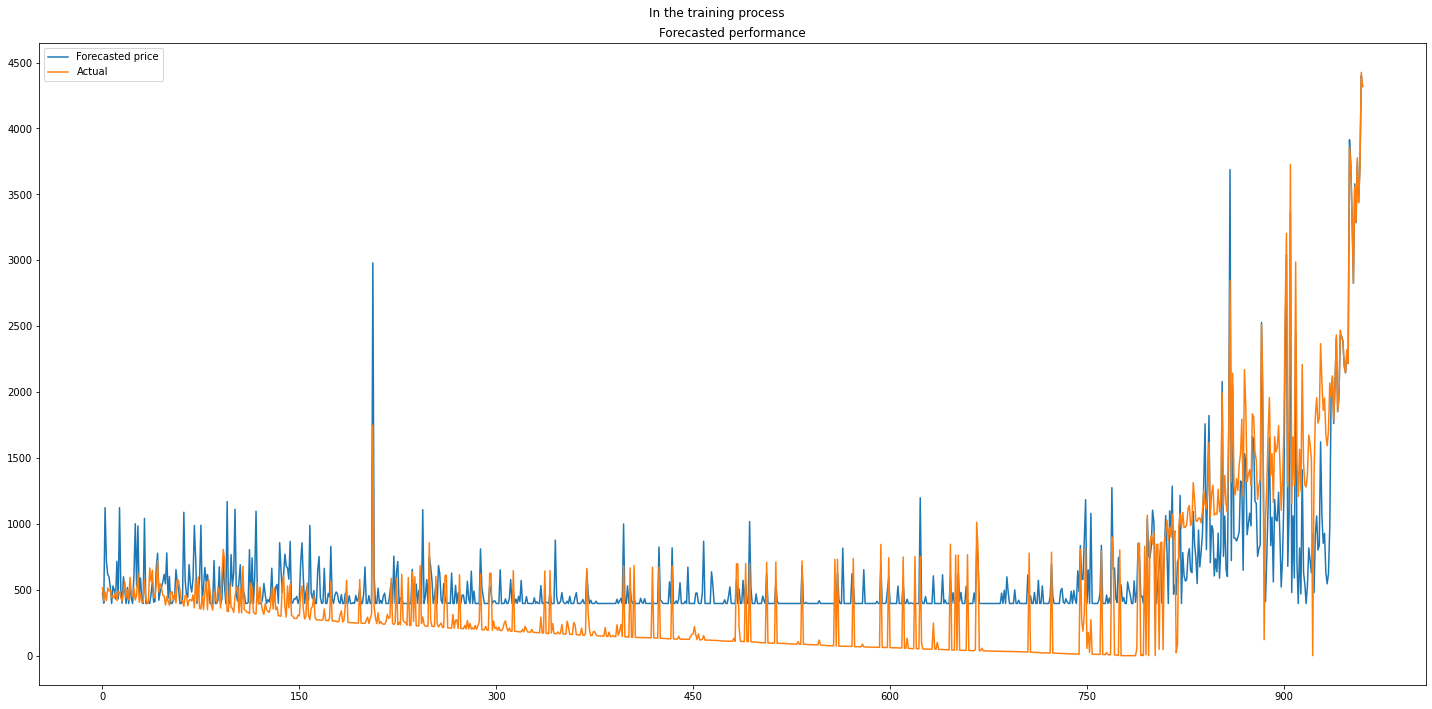

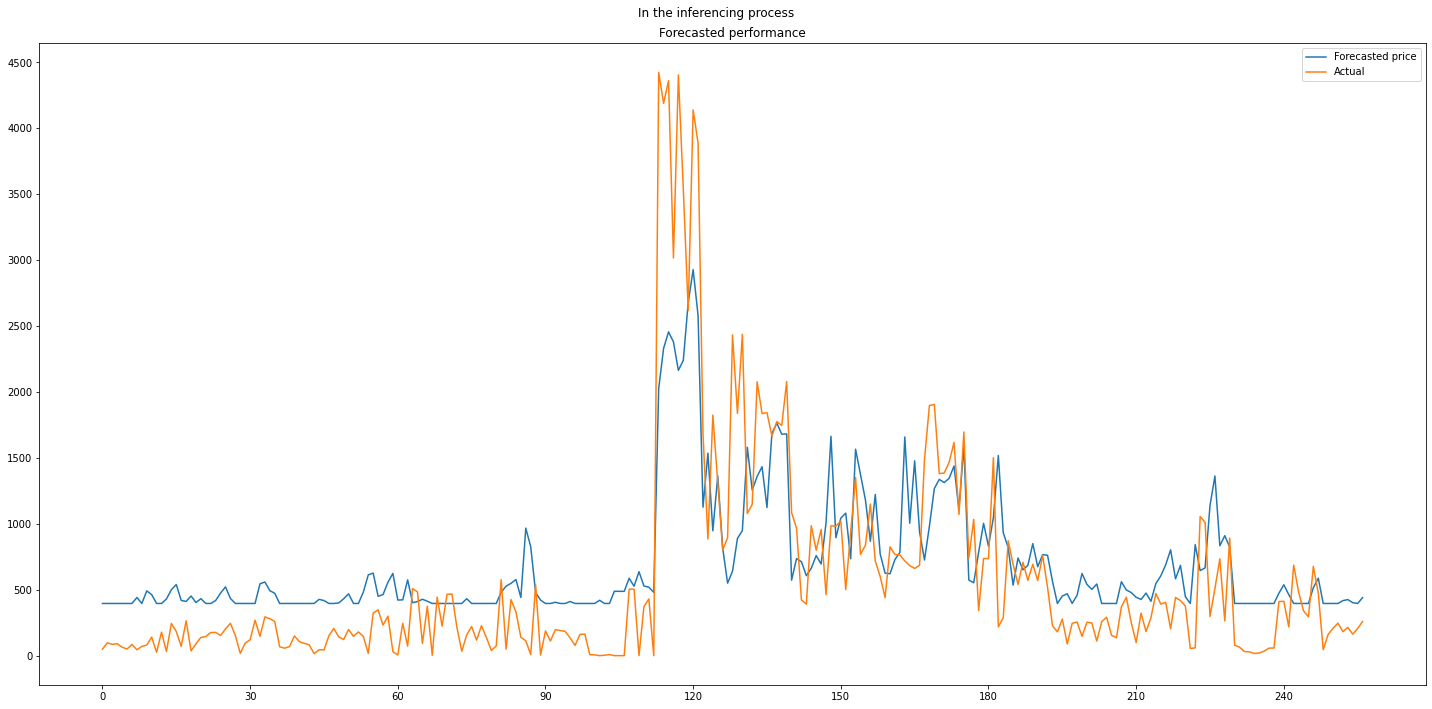

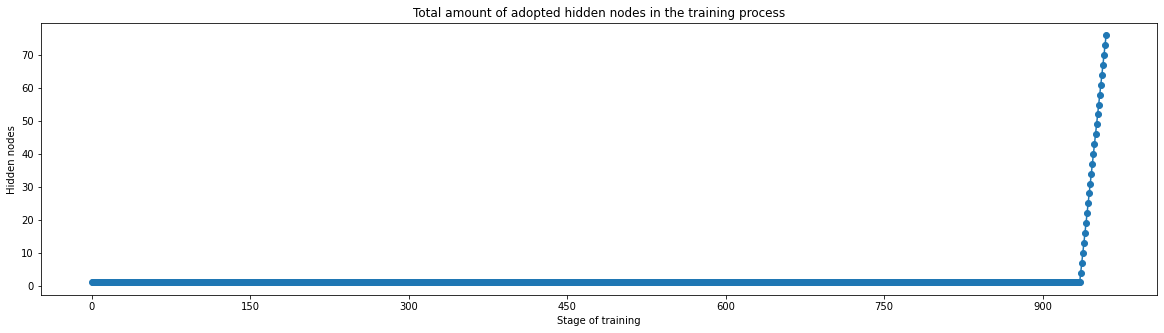

In [28]:
## 取得對應訓練與測試資料
x_train, y_train, x_test, y_test = data_preparation(demand_x_encode, demand_y_encode)

## 變為Tensor型態
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train).reshape(-1,1)

x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test).reshape(-1,1)


x_train = np.delete(x_train, 2, axis=1)
date = x_test[:,2]
x_test = np.delete(x_test, 2, axis=1)

## 創建對應存放資料
evaluation_table_train = pd.DataFrame(columns=["Stage","MAE","RMSE","Accuracy(500)","SD of absolute error","Step4","Step6.1","Step6.2","Adopted_hidden_node"])
evaluation_table_test = pd.DataFrame(columns=["Stage","MAE","RMSE","Accuracy(500)","SD of absolute error","Step4","Step6.1","Step6.2","Adopted_hidden_node"])
    
threshold_for_error = 1100


start = time.time()

## Record the number of each step
nb_step4 = 0
nb_step6_1 = 0
nb_step6_2 = 0


lower = torch.mean(y_train)-0.1*torch.std(y_train)
upper = torch.mean(y_train)+0.1*torch.std(y_train)
nonoutlier_index = torch.nonzero((y_train[:,0]>lower)&(y_train[:,0]<upper), as_tuple =False).reshape([-1])

initial_x = x_train[nonoutlier_index[:x_train.shape[1]+1]]
initial_y = y_train[nonoutlier_index[:x_train.shape[1]+1]]

x_train = x_train[x_train.shape[1]:]
y_train = y_train[x_train.shape[1]:]


network = Network(1,initial_x,initial_y)

network.nb_node_acceptable = torch.IntTensor([1 for _ in range(initial_x.shape[0])])
network.threshold_for_error = threshold_for_error

initializing(network, initial_x, initial_y)
nb_step4 += initial_x.shape[0]

# print("<<Initializing後看一下差異>>")
# yo,loss = network.forward()
# print(torch.abs(network.y-yo))
# print("threshold_for_error:",network.threshold_for_error)

remainder = x_train.shape[0]
# print("Remainder:",remainder)

for i in range(remainder):
# for i in range(10):
    
    print("現在訓練到第幾筆資料: %d"%(i+x_train.shape[1]+2))
#     print("剩餘X 資料",x_train.shape)
#     print("剩餘Y 資料",y_train.shape)

    sorted_index = selecting(network, x_train, y_train)


    ## Add new data for training
#     print("現在要進去模型的數據，索引%d，y="%(sorted_index[0]),y_train[sorted_index[0]].data)        
    network.addData(x_train[sorted_index[0]], y_train[sorted_index[0]])
#     print("目前模型的Data狀態",network.y.shape)
    x_train = np.delete(x_train, sorted_index[0], 0)
    y_train = np.delete(y_train, sorted_index[0], 0)

    yo,loss = network.forward()
#     print("<<預測值>>")
#     print(yo)
#     print("<<差異>>")
#     print(torch.abs(yo-network.y))
#     print("threshold_for_error:",network.threshold_for_error)
#     print("Loss值")
#     print(loss)

    pre_network = copy.deepcopy(network)

    if not torch.all(torch.abs(network.y-yo)<=network.threshold_for_error):
        print(network.threshold_for_error)
        network.acceptable = False
        network = matching(network)

#         print("<<Matching後看一下差異>>")
        yo,loss = network.forward()
#         print(torch.abs(yo-network.y))
#         print("threshold_for_error:",network.threshold_for_error)

        if network.acceptable == False:

            network = copy.deepcopy(pre_network)
            network.acceptable = False
            cramming(network)

#             if network.acceptable == False:
#                 sys.exit("Cramming failed")  

            print("<<Cramming後看一下差異>>")
            yo,loss = network.forward()
            network.threshold_for_error = torch.max(torch.FloatTensor([threshold_for_error,torch.max(torch.abs(network.y-yo))]))
            print(torch.abs(yo-network.y))
            print("threshold_for_error:",network.threshold_for_error)
            nb_step6_2 += 1

        else:
            nb_step6_1 += 1

    else:
        nb_step4 += 1

    network = reorganizing(network)
#     print("<<Reorganizing後看一下差異>>")
    yo,loss = network.forward()
#     print(torch.abs(yo-network.y))
#     print("threshold_for_error:",network.threshold_for_error)

    network.nb_node_acceptable = torch.cat([network.nb_node_acceptable, torch.IntTensor([network.linear1.bias.data.shape[0]])],0)
    print("看一下 hidden node")
    print(network.nb_node_acceptable)

#     print("使用裝置",(list(network.parameters())[0].device))
#     print("累計時間(s)",time.time()-start)
#         print(network.state_dict())
    print("-"*90)




print("<<The performance>>")
evaluation_table_train, evaluation_table_test = validation(network, nb_step4, nb_step6_1, nb_step6_2, x_train, y_train,x_test, y_test,evaluation_table_train,evaluation_table_test,date)

evaluation_table_train.to_csv("evaluation_table_train.csv",index=False)
evaluation_table_test.to_csv("evaluation_table_inferencing.csv",index=False)

end = time.time()
print("總計時間(s)", end-start)

## original Back propagation learning algorithm (BP)

In [29]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Flatten, Input

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
tf.compat.v1.keras.backend.set_session(sess)

In [30]:
pre_result = pd.read_csv("pre_result.csv")

In [31]:
x_train, y_train, x_test, y_test = data_preparation(demand_x_encode, demand_y_encode)

In [32]:
def buildTwoLayerNN(input_shape):

    keras.backend.clear_session()
    model = Sequential()
    model.add(Dense(units=20, activation ="relu", input_shape=(input_shape,)))
    model.add(Dense(units=1)) 

    model.compile(optimizer="Adam", loss="mean_squared_error")

    return model

In [33]:
input_shape = x_train.shape[1]
model = buildTwoLayerNN(input_shape)

In [34]:
model.fit(x_train, y_train, verbose=0)

In [35]:
pre_result["ANN"] = model.predict(x_test)

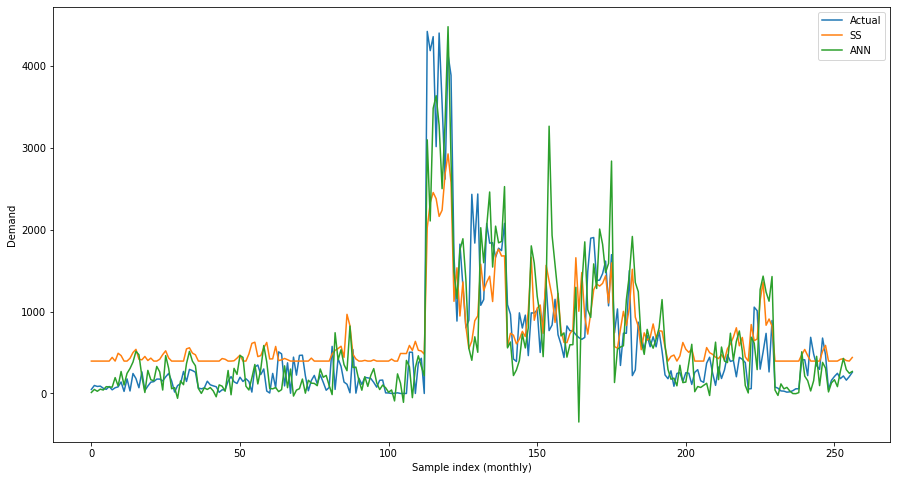

In [36]:
plt.figure(figsize=(15,8))
for i in range(pre_result.shape[1]):
    plt.plot(pre_result.iloc[:,i], label=pre_result.columns[i])

plt.legend()
plt.xlabel("Sample index (monthly)")
plt.ylabel("Demand")
plt.savefig('comparison.png')

In [37]:
evaluation_results = pd.DataFrame(columns=["Model","MAE","SD of absolute error","RMSE","Accuracy(500)"])

mae = tf.keras.losses.MeanAbsoluteError()
mse = tf.keras.losses.MeanSquaredError()

for i in range(1,pre_result.shape[1]):
    
    val_mae = mae(pre_result["Actual"], pre_result.iloc[:,i]).numpy()
    
    val_rmse = tf.math.sqrt(mse(pre_result["Actual"], pre_result.iloc[:,i])).numpy()
        
    y_true = pre_result["Actual"]
    y_pred = pre_result.iloc[:,i]

    val_sdae = tf.math.reduce_std(tf.math.abs(y_true - y_pred)).numpy()
    
    total_times = y_true.shape[0]
    correct_times = 0
        
    for _ in range(total_times): 

        correct_times = np.count_nonzero(abs(y_true-y_pred) < 500)

    
    new_result = pd.DataFrame({

        "Model" : [pre_result.columns[i]],
        "MAE" : [val_mae],
        "SD of absolute error": val_sdae,
        "RMSE" : [val_rmse],
        "Accuracy(500)" : [correct_times/total_times]
        
    })

    evaluation_results = evaluation_results.append(new_result, ignore_index=True)

In [38]:
evaluation_results.to_csv("judgement.csv", index=False)